

---

# Hypothesis Testing: ANOVA

## **Honing in on Inspection:**

#### **Experimental Thinking for Decision Science:**
* I suspect that if Products are Displayed more Centrally - i.e., closer to the natural default position of the eyes & easier to reach via Mouse Cursor, then Consumers will Spend more on them.

So:

* Suspected: Higher "...-Middle" Count -> Higher 'order' and 'price' values.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/model_ready_clickstream_data.csv')

df.drop(columns = 'Unnamed: 0', inplace = True)

# Fixing an Issue of Inappropriate Data Types still Popping up

df['year'] = df['year'].astype('object')
df['price 2'] = df['price 2'].astype('object') # Binary variable: is Price of product higher than the Average Price for the Entire product category

df.sample(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,year,month,day,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,price,price 2,page,price category,week,month phase
155717,2008,8,5,4,29,22720,4,P82,6,4,2,48,1,5,High,First Week,B
49766,2008,5,2,3,29,7135,2,B31,9,5,1,57,1,2,High,First Week,A
94590,2008,6,10,1,9,13831,1,A7,3,3,1,43,2,1,Mid,Second Week,A
64306,2008,5,15,14,29,9290,1,A22,4,2,1,62,1,2,Expensive,Third Week,A
139139,2008,7,21,2,9,20421,3,C59,5,2,2,52,1,4,High,Third Week,B
21020,2008,4,11,7,29,3065,2,B9,1,3,1,48,2,1,High,Second Week,A
73450,2008,5,22,1,9,10610,1,A5,3,2,1,43,2,1,Mid,Fourth Week,A


In [ ]:
# Mapping

df['location'] = df['location'].map({
    1: 'Top-Left',
    2: 'Top-Middle',
    3: 'Top-Right',
    4: 'Bottom-Left',
    5: 'Bottom-Middle',
    6: 'Bottom-Right'
})

# Getting the Total & Average Pricing as well as Number of Clicks ('order') by Location of Product

positional = df.groupby('location')[['order', 'price']].agg(['count', 'mean', 'sum'])
positional.sort_values(by = ('order', 'sum'), ascending = False)

order                     price                    
               count       mean     sum  count       mean      sum
location                                                          
Top-Left       34532   9.447730  326249  34532  45.219738  1561528
Top-Middle     33383   9.621035  321179  33383  42.543600  1420233
Bottom-Left    27377   9.785659  267902  27377  45.028929  1232757
Bottom-Middle  27783   9.508476  264174  27783  40.715402  1131196
Top-Right      21656  10.489241  227155  21656  47.545207  1029639
Bottom-Right   20743  10.503688  217878  20743  42.077954   872823

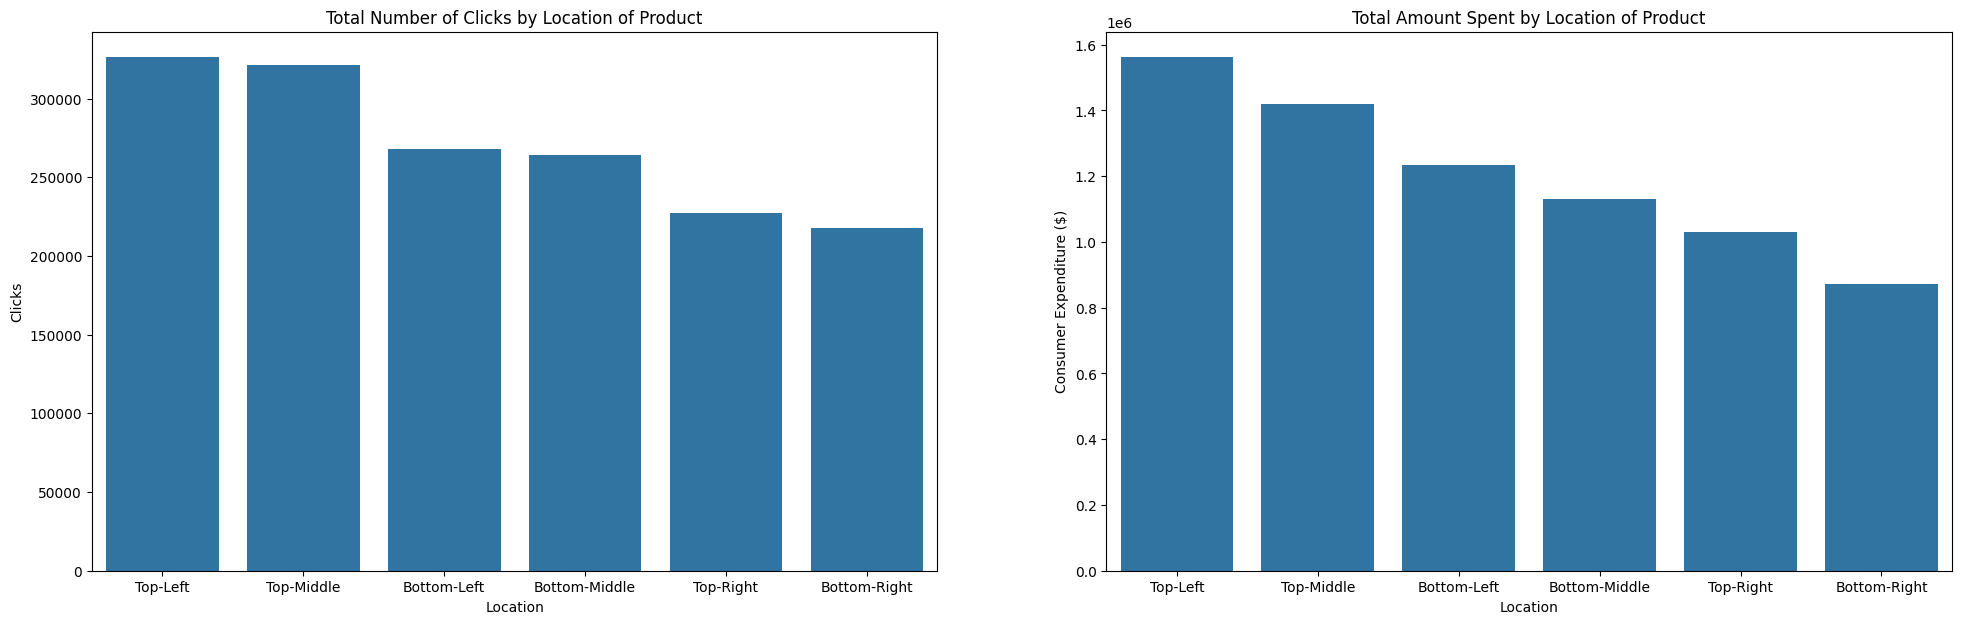

In [ ]:
# Sorting first

positional1 = positional.sort_values(by = ('order', 'sum'), ascending = False)
positional2 = positional.sort_values(by = ('price', 'sum'), ascending = False)

# Let's Visualize and see Better!

plt.figure(figsize = (24, 7))

plt.subplot(1, 2, 1)
sns.barplot(x = positional1.index, y = positional1[('order', 'sum')], data = positional1)
plt.xlabel('Location')
plt.ylabel('Clicks')
plt.title('Total Number of Clicks by Location of Product')

plt.subplot(1, 2, 2)
sns.barplot(x = positional2.index, y = positional2[('price', 'sum')], data = positional2)
plt.xlabel('Location')
plt.ylabel('Consumer Expenditure ($)')
plt.title('Total Amount Spent by Location of Product')

plt.show()



---

In both Measures - of Total Clicks and Amount Spent - the "...-Middle" products do stand strong, albeit not too much, but I believe a better way to Dig Deeper would be to see Average Amount spent *per click*.

If the product was placed nearer to the center of the page and was, thus, easier to view, *how much of an impact did that have?*

---



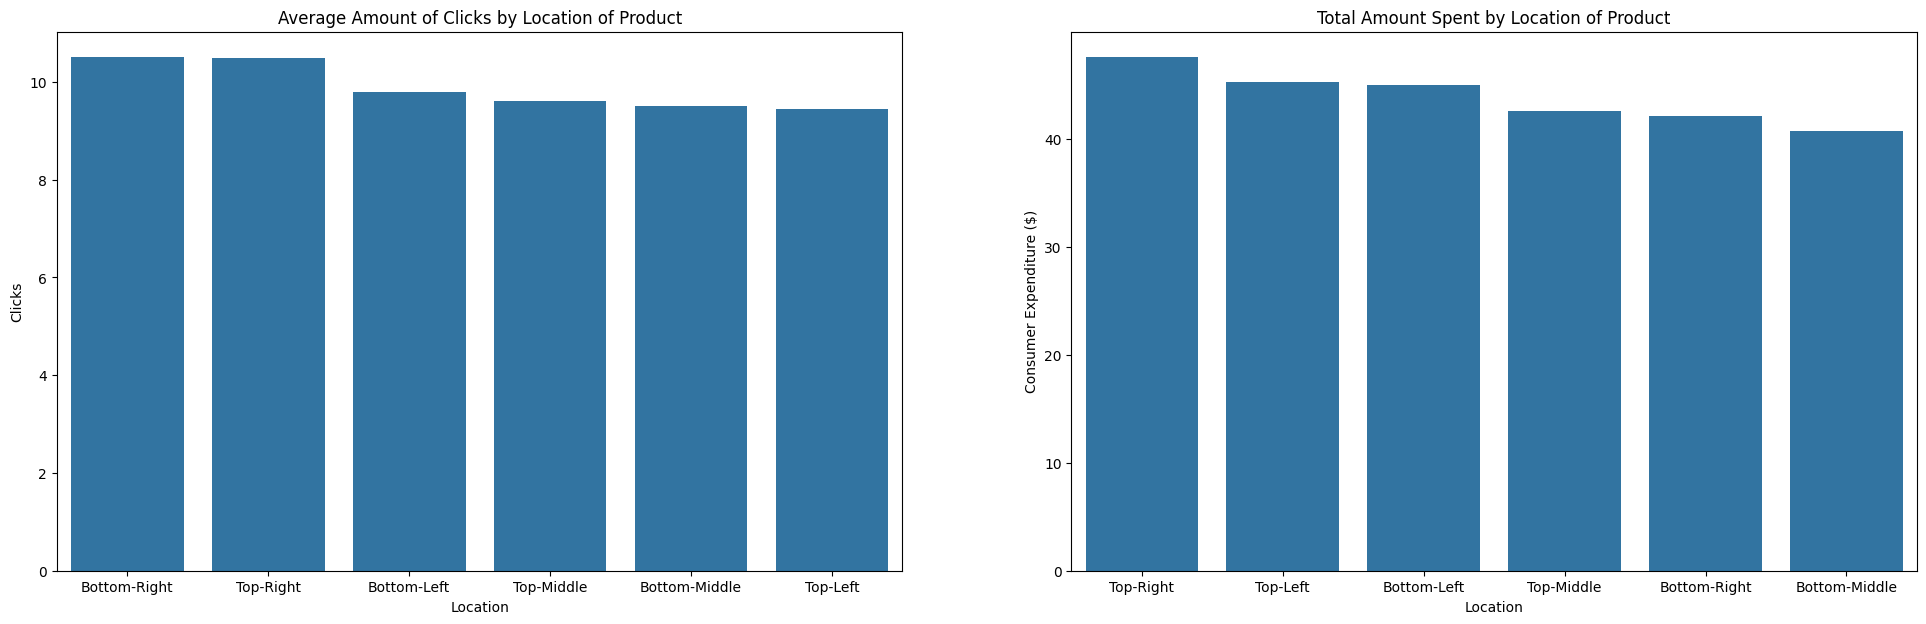

In [ ]:
# Sorting first

positional3 = positional.sort_values(by = ('order', 'mean'), ascending = False)
positional4 = positional.sort_values(by = ('price', 'mean'), ascending = False)

# Let's Visualize and see Better!

plt.figure(figsize = (24, 7))

plt.subplot(1, 2, 1)
sns.barplot(x = positional3.index, y = positional3[('order', 'mean')], data = positional3)
plt.xlabel('Location')
plt.ylabel('Clicks')
plt.title('Average Amount of Clicks by Location of Product')

plt.subplot(1, 2, 2)
sns.barplot(x = positional4.index, y = positional4[('price', 'mean')], data = positional4)
plt.xlabel('Location')
plt.ylabel('Consumer Expenditure ($)')
plt.title('Total Amount Spent by Location of Product')

plt.show()



---

Although not by a lot, the -Middle products do not have good Measures on Average Clicks and Average Amount Spent by Customers per placement. This alludes to the fact that Product Placement nearer to the Center - or anywhere for that matter - does not make much of a Difference in Customer Viewership & Expenditure.

So, will Test this officially through **Hypothesis Testing**!

---



In [ ]:
# First, Importantly: Interquartile Range- (IQR-) Based Outlier Removal

col_to_process = ['order']

# Function: Outlier Removal

def iqr_remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtering the Data
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Applying the Function - Outlier Removal Complete

df_filtered = iqr_remove_outliers(df, col_to_process)



---

### Hypothesis Testing: **ANOVA** to see for Significant Differences in Customer Expenditure by Location of Product

In [ ]:
loc_orders = df_filtered[['location', 'order']]

# Null Hypothesis: There is no Significant Difference in the Mean number of Clicks ('order') across Different Product Locations
# Alternative Hypothesis: There is a Significant Difference in Number of Clicks by Customers based on Location of Product, for at least one pair of Product Locations
# (One-Way ANOVA Needed only)

locs = loc_orders.groupby('location').groups

## Extracting each Individual Group, Ensuring to get the 'order' values for each

top_left = loc_orders['order'][locs['Top-Left']]
top_middle = loc_orders['order'][locs['Top-Middle']]
top_right = loc_orders['order'][locs['Top-Right']]
bottom_left = loc_orders['order'][locs['Bottom-Left']]
bottom_middle = loc_orders['order'][locs['Bottom-Middle']]
bottom_right = loc_orders['order'][locs['Bottom-Right']]

In [ ]:
# Performing the One-Way ANOVA

import scipy.stats as stats

f_stat, p_val = stats.f_oneway(top_left, top_middle, top_right, bottom_left, bottom_middle, bottom_right)

print(f"F-Statistic: {f_stat}", '\n', f"P-value: {p_val}")

F-Statistic: 43.96604586652167 
 P-value: 1.7436788328752422e-45



---


* F-Statistic of 43.97 indicates a larger Variation *between* the groups than *within* each group.

* P-Value of 1.74 * 10^-45 indicates that we Reject the Null Hypothesis and Accept that there is a statistically significant difference between at least one pair of Product Locations regarding the number of Clicks by Customers.

---



       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
  Bottom-Left Bottom-Middle  -0.1307 0.1546 -0.2856  0.0242  False
  Bottom-Left  Bottom-Right   0.3765    0.0  0.2085  0.5445   True
  Bottom-Left      Top-Left  -0.2658    0.0 -0.4131 -0.1186   True
  Bottom-Left    Top-Middle  -0.1165 0.2206 -0.2648  0.0319  False
  Bottom-Left     Top-Right   0.3539    0.0   0.188  0.5198   True
Bottom-Middle  Bottom-Right   0.5072    0.0  0.3399  0.6746   True
Bottom-Middle      Top-Left  -0.1351 0.0903 -0.2816  0.0113  False
Bottom-Middle    Top-Middle   0.0142 0.9998 -0.1334  0.1618  False
Bottom-Middle     Top-Right   0.4846    0.0  0.3193  0.6498   True
 Bottom-Right      Top-Left  -0.6424    0.0 -0.8027 -0.4821   True
 Bottom-Right    Top-Middle   -0.493    0.0 -0.6543 -0.3317   True
 Bottom-Right     Top-Right  -0.0227 0.9992 -0.2003  0.1549  F

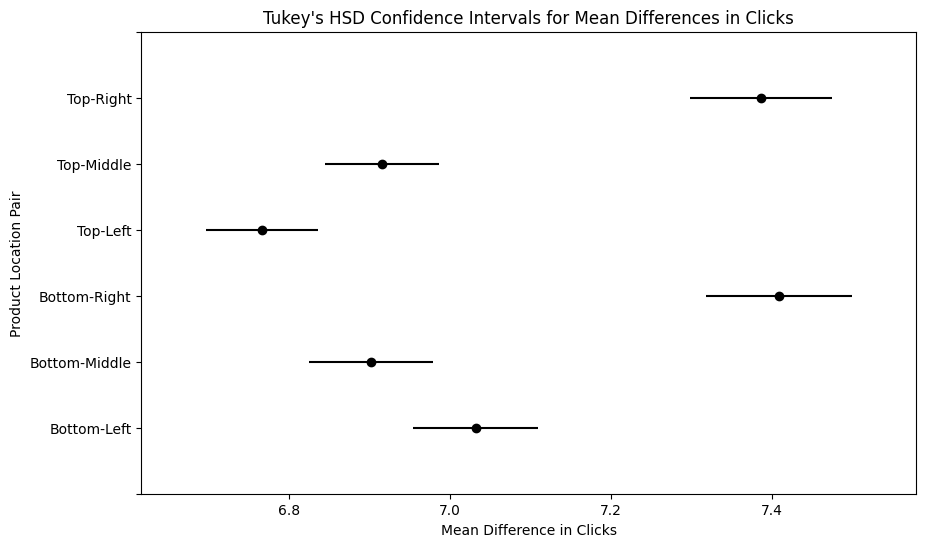

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

tukey = pairwise_tukeyhsd(endog = loc_orders['order'], # Dependent Variable
                          groups = loc_orders['location'], # Independent Variable (Locations)
                          alpha = 0.05) # Significance Level

print(tukey.summary(), '\n') # meandiff = *Mean of Group 2 - Mean of Group 1*

tukey.plot_simultaneous() # Plotting the Group Confidence Intervals
plt.vlines(x = 0, ymin = -0.5, ymax = 5.5, color = 'red', linestyle = '--', linewidth = 2)
plt.title("Tukey's HSD Confidence Intervals for Mean Differences in Clicks")
plt.xlabel('Mean Difference in Clicks')
plt.ylabel('Product Location Pair')
plt.show()

# In the majority of the "meandiff" cases, the "-Middle" group Average is Higher in Clicks as well as Statistically Significant.


---

# Hypothesis Testing: Chi-Squared Test


## **Chi-Squared Test of Independence** to Check if there is a Relationship between 'order' and 'page';

* I Hypothesize that the higher the `page` number, the more time and effort people will take to find that particular product and, thus, there will be fewer clicks (`order` or views) on it, leading to lower overall expenditure on it.

---

## Chi-Squared Test for 'page' and 'order'

To perform a Chi-Squared test, both variables need to be categorical. Since 'order' (clicks) is Numerical, I will first Categorize it into bins. I will use `pd.qcut` to create three Quantiles for 'order' (representing Low, Medium, and High click counts).

In [ ]:
from scipy.stats import chi2_contingency

# Confirming the Data Type of the 'order' column

print(f"Data type of 'order' column: {df_filtered['order'].dtype}")

# Categorizing 'order' into Bins for the Chi-Squared test

df_filtered['order_category'] = pd.qcut(df_filtered['order'], q = 3, labels = ['Low Clicks', 'Medium Clicks', 'High Clicks'])

# Creating a Contingency Table between 'page' and 'order_category' (RAW COUNTS for the Chi-Squared test)

contingency_table_order = pd.crosstab(df_filtered['page'], df_filtered['order_category'])

print("Contingency Table (Page vs. Order Category - Raw Counts):") # Used for the Statistical Test
display(contingency_table_order)

Data type of 'order' column: int64
Contingency Table (Page vs. Order Category - Raw Counts):


order_category,Low Clicks,Medium Clicks,High Clicks
page,,,
1,41397,26836,21089
2,11598,12757,13326
3,3812,5789,7386
4,1464,2291,3858
5,403,695,1250


In [ ]:
# Performing Chi-Squared Test of Independence

chi2_order, p_order, dof_order, expected_order = chi2_contingency(contingency_table_order)

print(f"\nChi-Squared Statistic (Page vs. Order): {chi2_order}")
print(f"P-value (Page vs. Order): {p_order}")
print(f"Degrees of Freedom (Page vs. Order): {dof_order}")

alpha = 0.05
print(f"Significance Level: {alpha}")
if p_order < alpha:
    print("Result: Reject the null hypothesis. There is a statistically significant relationship between page number and order (clicks).")
else:
    print("Result: Fail to reject the null hypothesis. There is no statistically significant relationship between page number and order (clicks).")

# The Normalized-by-Row Table for Interpretation of Directionality AFTER the Test

print("\nContingency Table (Page vs. Order Category - Normalized by Row for Interpretation):")
display(pd.crosstab(df_filtered['page'], df_filtered['order_category'], normalize = 'index'))


Chi-Squared Statistic (Page vs. Order): 8406.623852503935
P-value (Page vs. Order): 0.0
Degrees of Freedom (Page vs. Order): 8
Significance Level: 0.05
Result: Reject the null hypothesis. There is a statistically significant relationship between page number and order (clicks).

Contingency Table (Page vs. Order Category - Normalized by Row for Interpretation):


order_category,Low Clicks,Medium Clicks,High Clicks
page,,,
1,0.463458,0.300441,0.236101
2,0.307794,0.338553,0.353653
3,0.224407,0.340790,0.434803
4,0.192303,0.300933,0.506765
5,0.171635,0.295997,0.532368
